In [42]:
import os
import sys
import torch
import wandb
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset
from typing import  Dict
from pathlib import Path
from tqdm import tqdm, trange
from functools import partial
from vit_sae_analysis.dashboard_fns import get_feature_data, FeatureData
from IPython.display import Image, display



sys.path.append("..")

from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_analysis.visualizer import data_fns, html_fns
from sae_analysis.visualizer.data_fns import get_feature_data, FeatureData
from sae_training.config import ViTSAERunnerConfig
from sae_training.vit_runner import vision_transformer_sae_runner
from sae_training.train_sae_on_vision_transformer import train_sae_on_vision_transformer
from vit_sae_analysis.dashboard_fns import get_feature_data, FeatureData
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.utils import ViTSparseAutoencoderSessionloader
from vit_sae_analysis.dashboard_fns import get_all_model_activations, get_sae_activations
from torchvision import transforms, datasets
from torchvision.utils import save_image
from PIL import Image as load_image



import os
import shutil


if torch.backends.mps.is_available():
    device = "mps" 
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
sae_path = "checkpoints/layer_10/final_sparse_autoencoder_vit_base_patch32_clip_224_10_resid_49152.pt"

loaded_object = torch.load(sae_path)

cfg = loaded_object['cfg']

state_dict = loaded_object['state_dict']

sparse_autoencoder = SparseAutoencoder(cfg)

sparse_autoencoder.load_state_dict(state_dict)

sparse_autoencoder.eval()

loader = ViTSparseAutoencoderSessionloader(cfg)

model = loader.get_model(cfg.model_name)
model.to(cfg.device)

torch.cuda.empty_cache()
sparse_autoencoder.eval()


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

In [43]:

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((sparse_autoencoder.cfg.image_width, sparse_autoencoder.cfg.image_height)),  # Resize the image to WxH pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])
dataset = load_dataset(sparse_autoencoder.cfg.dataset_path, split="train")

if sparse_autoencoder.cfg.dataset_path=="cifar100":
    image_key = 'img'
else:
    image_key = 'image'


# Select a smaller dataset to process the images. By default, the datset contains at most 250_000 images
max_dataset_size = 250_000 # Put this in the cfg file
if len(dataset)>max_dataset_size:
    dataset = dataset.shuffle().select(range(max_dataset_size))
    
iterable_dataset = iter(dataset)

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/39 [00:00<?, ?it/s]

In [44]:
def load_random_iage_and_activations(num_images):
    images = []
    for image in trange(num_images, desc = "Getting images for dashboard"):
        with torch.no_grad():
            try:
                images.append(transform(next(iterable_dataset)[image_key]))
            except StopIteration:
                iterable_dataset = iter(dataset.shuffle())
                images.append(transform(next(iterable_dataset)[image_key]))
    images = torch.stack(images, dim=0)
    images = images.to(sparse_autoencoder.cfg.device)

    model_activations = get_all_model_activations(images, model, sparse_autoencoder.cfg) # tensor of size [batch, d_resid]
    sae_activations = get_sae_activations(model_activations, sparse_autoencoder, torch.tensor(range(cfg.d_sae))) # tensor of size [batch, feature_idx]
    del model_activations
    return images, sae_activations

images, sae_activations = load_random_iage_and_activations(50)

Getting images for dashboard: 100%|██████████| 50/50 [00:00<00:00, 523.28it/s]


torch.Size([50, 3, 224, 224])


Dashboard: forward pass images through ViT: 0it [00:00, ?it/s]
Dashboard: obtaining sae activations: 0it [00:00, ?it/s]


In [46]:
def load_image_and_activations(image_path):
    new_image = load_image.open(image_path)
    new_image = transform(new_image).unsqueeze(dim=0).to(device)
    model_activations = get_all_model_activations(new_image, model, sparse_autoencoder.cfg) # tensor of size [batch, d_resid]
    sae_activations = get_sae_activations(model_activations, sparse_autoencoder, torch.tensor(range(cfg.d_sae))) # tensor of size [batch, feature_idx]
    del model_activations
    return (new_image[0], sae_activations[0])

new_image, new_sae_activations = load_image_and_activations("PXL_20240301_032537263.jpg")

Dashboard: forward pass images through ViT: 0it [00:00, ?it/s]
Dashboard: obtaining sae activations: 0it [00:00, ?it/s]

torch.Size([3, 224, 224])
torch.Size([49152])


In [52]:
def show_maes(feature, activation):
    print(f"Feature {feature}")
    print(f"Input image activation: {activation}")
    print()
    feature_path = f"./layer_10_dashboard/{feature}/max_activating"
    maes_file_names = os.listdir(feature_path)
    activations = [float(i.split(".png")[0]) for i in maes_file_names]
    paths = [f"{feature_path}/{i}" for i in maes_file_names]

    # def get_feature_maes(feature):
    for image in range(len(paths)):
        print(f"Activation: {activations[image]}")
        display(Image(filename=paths[image]))
    print("-----")
    print("\n"*5)



In [47]:
def show_all_sae_info(image, activations):
    px.imshow(image.permute(1,2,0).detach().cpu().numpy()).show()

    px.line(
        activations.detach().cpu(),
    ).show()

    vals, inds = torch.topk(activations.detach().cpu(), 5)
    for val, ind in zip(vals,inds):
        show_maes(ind, val.item())

Feature 43584
Input image activation: 6.758359909057617
Activation: 9.2


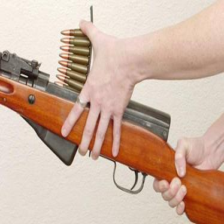

Activation: 9.1


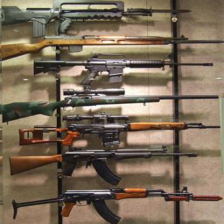

Activation: 8.1


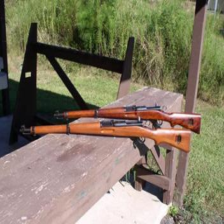

Activation: 7.6


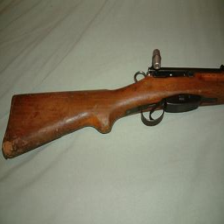

Activation: 7.5


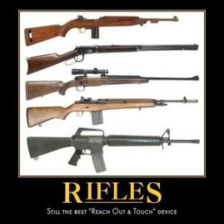

Activation: 7.4


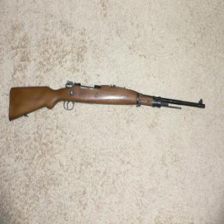

Activation: 7.1


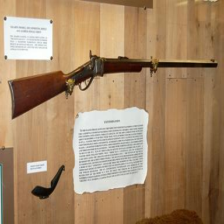

Activation: 6.8


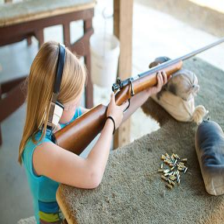

Activation: 6.7


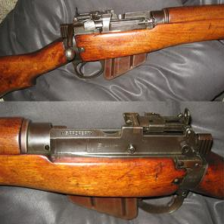

-----






Feature 17139
Input image activation: 5.9976043701171875
Activation: 10.0


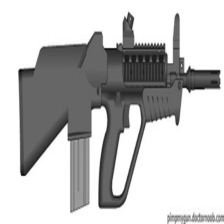

Activation: 9.5


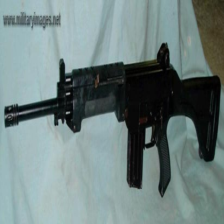

Activation: 8.9


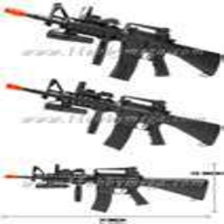

Activation: 8.1


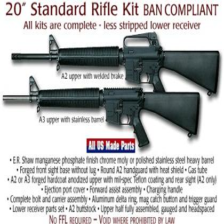

Activation: 7.8


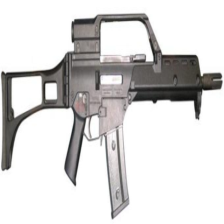

Activation: 7.6


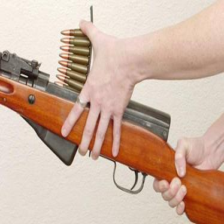

Activation: 7.5


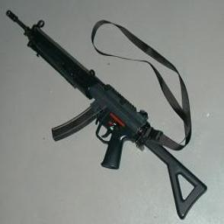

Activation: 7.1


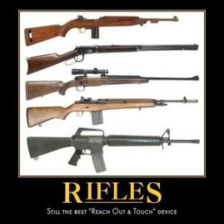

-----






Feature 46355
Input image activation: 5.26105260848999
Activation: 9.9


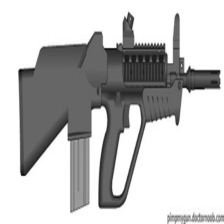

Activation: 9.6


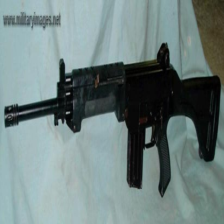

Activation: 8.8


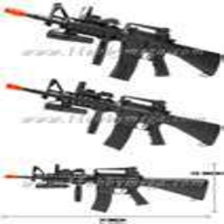

Activation: 7.9


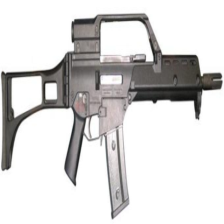

Activation: 7.8


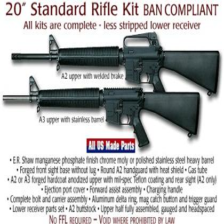

Activation: 7.6


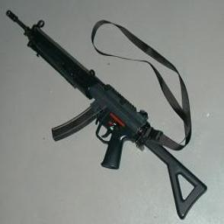

Activation: 7.1


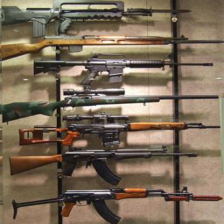

Activation: 7.0


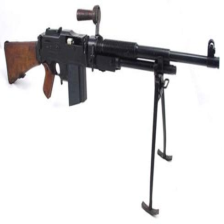

Activation: 6.6


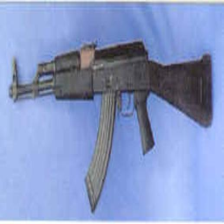

-----






Feature 35612
Input image activation: 4.998475074768066
Activation: 6.2


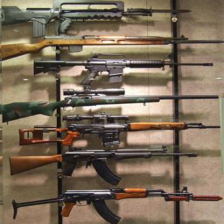

Activation: 5.9


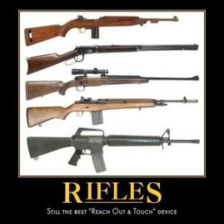

Activation: 5.5


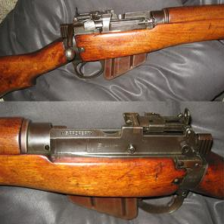

Activation: 5.3


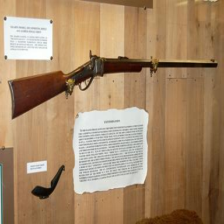

Activation: 5.1


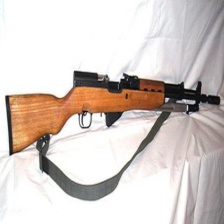

Activation: 4.9


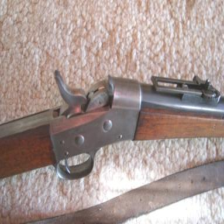

-----






Feature 4645
Input image activation: 4.920314311981201
Activation: 6.0


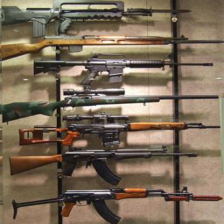

Activation: 5.8


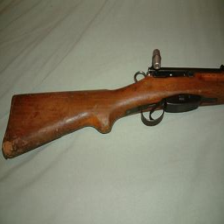

Activation: 5.7


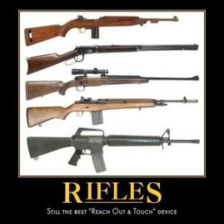

Activation: 5.1


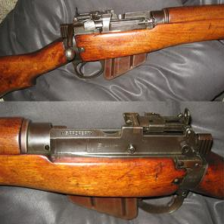

Activation: 5.0


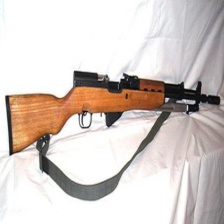

Activation: 4.8


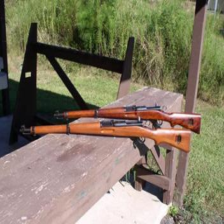

Activation: 4.7


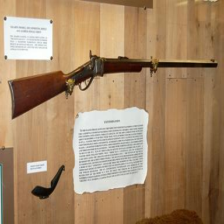

-----








In [56]:
image_index = 9
show_all_sae_info(images[image_index], sae_activations[image_index])
#show_all_sae_info(new_image, new_sae_activations)